In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


axis_label_fontsize = 14
title_fontsize = 13
legend_fontsize = 10
parent_nace_list = ["A","B","C","F","H","G"]
tick_label_fontsize =10
pd.set_option("display.max_columns",100)

colors = [
    "#2ab421",   # Less vivid green
    "#f93a2e",  # Vivid red
    "#d02670",  # Strong pink
    "#ff7a00",  # Bright orange
    "#1dd3c1",  # Vivid turquoise
    "#8a2be2",   # Electric purple
    "#ffafd2",  # Bright pink
    "#fff537",  # Bright yellow
    "#4589ff",  # Vibrant blue
    "#d4b237",  # Bold yellow-orange
    "#c677e2",  # Lively purple
    "#a2a9b0",  # Muted grayish blue
    "#baf0ce",  # Soft green
    "#b7e1ff",  # Light blue
    "#ebeced",  # Light gray
    "#dbc7ff",  # Pale purple
    "#6fdc8c",  # Bright green
]


## Historical low-carbon share of Hungary

In [168]:
df_final_consumption = pd.read_excel("data/7_2_annual_national_energy_balance_2014_2023.xlsx", sheet_name="2014")
df_final_consumption.columns = df_final_consumption.iloc[1,:]
df_final_consumption = pd.DataFrame([df_final_consumption.iloc[13,1:] - df_final_consumption.iloc[36,1:]])
df_final_consumption["year"] = 2014

for year in np.arange(2015,2023):
    df_temp = pd.read_excel("data/7_2_annual_national_energy_balance_2014_2023.xlsx", sheet_name=str(year))
    df_temp.columns = df_temp.iloc[1,:]
    df_temp = pd.DataFrame([df_temp.iloc[13,1:] - df_temp.iloc[36,1:]])
    df_temp["year"] = year
    
    df_final_consumption = pd.concat([df_final_consumption, df_temp], axis = 0)


for col in df_final_consumption:
    if (col != "Name") and (col != "year"):
        df_final_consumption[col] = df_final_consumption[col]*0.000278


df_final_consumption = df_final_consumption.reset_index(drop = True)
df_final_consumption["electricity_share"] = df_final_consumption["Electricity"] / (df_final_consumption["Electricity"] + df_final_consumption["Coal and coal products "] + df_final_consumption["Natural gas"] + df_final_consumption["Oil and petroleum products"])
df_final_consumption


1,Coal and coal products,Oil and petroleum products,Natural gas,Combustible renewables and waste,Nuclear,Water,Wind,Other non-combustible renewables,Electricity,Heat,Total,NaN,NaN,year,Solar,Geothermal,NaN,NaN,electricity_share
0,1.287969,68.614959,36.969552,4.688053,NaN,NaN,NaN,0.683602,24.333451,5.508848,142.086434,NaN,NaN,2014,NaN,NaN,NaN,NaN,0.185460
1,1.752243,74.886083,36.217701,4.733840,NaN,NaN,NaN,0.626890,25.472362,6.014252,149.703370,NaN,NaN,2015,NaN,NaN,NaN,NaN,0.184144
2,1.440267,74.038461,37.407402,5.117535,NaN,NaN,NaN,0.591862,26.218958,6.672834,151.487320,NaN,NaN,2016,NaN,NaN,NaN,NaN,0.188483
3,2.263756,80.221404,38.348905,5.458002,NaN,NaN,NaN,0.722244,27.265795,6.424302,160.704407,NaN,NaN,2017,NaN,NaN,NaN,NaN,0.184104
4,1.908813,85.626391,37.561025,6.364671,0.0,0.0,0.0,0.770338,28.070438,6.010360,166.312036,NaN,NaN,2018,NaN,NaN,NaN,NaN,0.183267
5,1.822372,86.738947,37.064378,7.059171,0.0,0.0,0.0,0.790354,28.626883,6.062902,168.165007,NaN,NaN,2019,NaN,NaN,NaN,NaN,0.185584
6,1.507960,80.509022,37.390889,7.867734,0.0,0.0,0.0,0.728360,27.793217,6.007302,161.804483,NaN,NaN,2020,NaN,NaN,NaN,NaN,0.188811
7,1.376924,88.142124,38.295112,8.850881,0.0,0.0,0.0,NaN,29.264393,6.555240,173.288649,NaN,NaN,2021,0.003058,0.800918,NaN,NaN,0.186304
8,1.131253,86.156648,30.929474,8.736067,0.0,0.0,0.0,NaN,28.980166,5.820486,162.686783,NaN,NaN,2022,0.003336,0.929354,NaN,NaN,0.196879


## Forecast Hungary Electricity Mix

In [169]:
df_mix = pd.read_csv("data/lowcarbon_electricity_share_Hungary_[2014-2023].csv")

def estimate_lowcarbon_elec_mix_growth(df_temp):
    
    lowcarbon_elec_vals = df_temp["lowcarbon_elec_share"].values
    years = np.arange(0,len(df_temp)).reshape((-1,1))
    elec_model = LinearRegression()
    elec_model.fit(years,lowcarbon_elec_vals)
    elec_coef = elec_model.coef_
    elec_intercept = elec_model.intercept_

    return elec_coef, elec_intercept

elec_coef,elec_intercept = estimate_lowcarbon_elec_mix_growth(df_mix[(df_mix.year>=2020) & (df_mix.year<=2024)])


In [170]:
forecast = np.arange(31)*elec_coef + elec_intercept

df_forecast = pd.DataFrame(zip(np.arange(2020,2051,1,dtype=int), forecast), columns=["year", "lowcarbon_elec_share"])
df_forecast["lowcarbon_elec_share"] = df_forecast["lowcarbon_elec_share"].clip(lower=0,upper=1)

## Low-carbon electricity share of observed years [2020-2023]

In [171]:
df = pd.read_csv("results/energy_consumption_firms_2020-2023.csv")

lowcarbon_elec_vals = df.loc[:,["low-carbon_elec_consumption_KWH_2020",
          "low-carbon_elec_consumption_KWH_2021",
          "low-carbon_elec_consumption_KWH_2022",
          "low-carbon_elec_consumption_KWH_2023"]].sum().values /df.loc[:,["total_consumption_KWH_2020",
          "total_consumption_KWH_2021",
          "total_consumption_KWH_2022",
          "total_consumption_KWH_2023"]].sum().values

fossil_vals = 1 - lowcarbon_elec_vals

df_lowcarbon_elec = pd.DataFrame({"source_year":[np.nan]*4,
                              "energy_consumed":lowcarbon_elec_vals,
                              "type":["lowcarbon"]*4,
                              "year":[2020,2021,2022,2023]
                              })

df_fossil = pd.DataFrame({"source_year":[np.nan]*4,
                              "energy_consumed":fossil_vals,
                              "type":["fossil"]*4,
                              "year":[2020,2021,2022,2023]
                              })

df_observed = pd.concat([df_lowcarbon_elec, df_fossil], axis = 0)


## Low-carbon electricity share of previous years [2014 - 2019]

In [172]:

df_hist = df_final_consumption.copy(deep = True).loc[:,["year","electricity_share"]]
df_hist["lowcarbon_elec_share"] = df_hist["electricity_share"]*df_mix["lowcarbon_elec_share"]
df_hist = df_hist.drop("electricity_share", axis = 1)
df_hist = df_hist.rename(columns = {"lowcarbon_elec_share":"energy_consumed"})
df_hist["type"] = "lowcarbon"
df_hist["source_year"] = np.nan
df_hist = df_hist[df_hist.year<=2019]
df_hist_fossil = df_hist.copy(deep = True)
df_hist_fossil["energy_consumed"] = 1-df_hist_fossil["energy_consumed"]
df_hist_fossil["type"] = "fossil"

df_hist_final = pd.concat([df_hist,df_hist_fossil])
df_hist_final = df_hist_final[["energy_consumed","type","year"]]
df_hist_final

1,energy_consumed,type,year
0,0.118697,lowcarbon,2014
1,0.115659,lowcarbon,2015
2,0.114107,lowcarbon,2016
3,0.109501,lowcarbon,2017
4,0.111504,lowcarbon,2018
5,0.113635,lowcarbon,2019
0,0.881303,fossil,2014
1,0.884341,fossil,2015
2,0.885893,fossil,2016
3,0.890499,fossil,2017


In [173]:
df

,firm_id,oil_purchases_2020,gas_purchases_2020,electricity_purchases_2020,oil_purchases_2021,gas_purchases_2021,electricity_purchases_2021,oil_purchases_2022,gas_purchases_2022,electricity_purchases_2022,oil_purchases_2023,gas_purchases_2023,electricity_purchases_2023,revenue_2020,revenue_2021,revenue_2022,revenue_2023,nace2,nace4,parent_nace,employment_2020,employment_2021,employment_2022,employment_2023,fossil_purchases_2020,fossil_purchases_2021,fossil_purchases_2022,fossil_purchases_2023,elec_consumption_KWH_2020,elec_price_2020,gas_consumption_KWH_2020,gas_price_2020,oil_consumption_KWH_2020,elec_consumption_KWH_2021,elec_price_2021,gas_consumption_KWH_2021,gas_price_2021,oil_consumption_KWH_2021,elec_consumption_KWH_2022,elec_price_2022,gas_consumption_KWH_2022,gas_price_2022,oil_consumption_KWH_2022,elec_consumption_KWH_2023,elec_price_2023,gas_consumption_KWH_2023,gas_price_2023,oil_consumption_KWH_2023,elec_share_2020,elec_share_2021,elec_share_2022,elec_share_2023,total_consumption_KWH_2020,total_consumption_KWH_2021,total_consumption_KWH_2022,total_consumption_KWH_2023,avg_total_consumption_KWH,low-carbon_elec_consumption_KWH_2020,low-carbon_elec_consumption_KWH_2021,low-carbon_elec_consumption_KWH_2022,low-carbon_elec_consumption_KWH_2023,low-carbon_elec_share_2020,low-carbon_elec_share_2021,low-carbon_elec_share_2022,low-carbon_elec_share_2023,fossil_share_2020,fossil_share_2021,fossil_share_2022,fossil_share_2023,decarbonization_trend,decarbonization_trend_intercept,decarbonization_rate,decarbonization_rate_initial_value,elec_trend,elec_intercept,elec_rate,elec_rate_initial_value
0,4,8082990,405711,217952,7924149,330131,494013,7554408,374278,147883,7145566,224834,190928,26656604691,2.563353e+10,2.593808e+10,2.472839e+10,1,141,A,109,112,115,116,8488701,8254280,7928686,7370400,3807.693584,57239.9,31814.481980,12752.4,211467.842813,8114.856696,60877.60,23420.854735,14095.60,170579.182471,1427.369063,103605.30,14047.391622,26643.95,129442.518185,1417.429750,134700.15,4546.445391,49452.7,111478.332680,0.015410,0.040150,0.009850,0.012069,247090.018377,202114.893902,144917.278870,117442.207821,177891.099743,2353.093572,5147.651478,936.810736,994.576406,0.009523,0.025469,0.006464,0.008469,0.990477,0.974531,0.993536,0.991531,-0.002217,0.015807,-0.142303,0.015307,-0.004032,0.025418,-0.164849,0.024500
1,5,8842200,252315,458083,7120133,149811,299827,7314638,337998,186107,8881659,181757,184355,62748596010,6.442413e+10,6.426222e+10,6.727587e+10,1,146,A,217,225,235,242,9094515,7269944,7652636,9063416,8002.861640,57239.9,19785.687400,12752.4,231330.356678,4925.079175,60877.60,10628.210222,14095.60,153271.533161,1796.307718,103605.30,12685.731658,26643.95,125334.131057,1368.632477,134700.15,3675.370607,49452.7,138563.206434,0.030885,0.029173,0.012848,0.009530,259118.905718,168824.822558,139816.170433,143607.209518,177841.777057,4945.640155,3124.219200,1178.952521,960.336532,0.019086,0.018506,0.008432,0.006687,0.980914,0.981494,0.991568,0.993313,-0.004727,0.020269,-0.341376,0.020589,-0.008039,0.032667,-0.370205,0.033261
2,6,6887633,459783,404137,8756072,321607,222144,8106511,425504,282883,6108483,199938,428653,81790739896,8.106951e+10,8.082737e+10,7.938054e+10,7,721,B,143,142,145,145,7347416,9077679,8532015,6308421,7060.407164,57239.9,36054.625012,12752.4,180194.815606,3649.026900,60877.60,22816.127018,14095.60,188487.571778,2730.391206,103605.30,15970.004448,26643.95,138902.637709,3182.275595,134700.15,4043.014840,49452.7,95298.748908,0.031617,0.016976,0.017324,0.031039,223309.847782,214952.725696,157603.033363,102524.039344,174597.411546,4363.218402,2314.756676,1792.010112,2232.926339,0.019539,0.010769,0.011370,0.021780,0.980461,0.989231,0.988630,0.978220,0.000732,0.014766,0.060910,0.014438,-0.000138,0.024447,-0.007451,0.024511
3,7,0,6937082,186293,0,8359705,184665,0,6888797,127257,0,6894255,124777,55954741790,5.693641e+10,5.816666e+10,5.654534e+10,7,729,B,187,180,177,169,6937082,8359705,6888797,6894255,3254.600375,57239.9,57002

## Energy consumption forecast

In [174]:
df['closest_positive_nace4'] = np.nan
df['closest_positive_revenue'] = np.nan
df['closest_positive_employment'] = np.nan
df['closest_positive_nace2'] = np.nan
df['closest_positive_elec_trend'] = np.nan  # New column for closest firm's elec_trend
df['closest_positive_elec_intercept'] = np.nan  # New column for closest firm's elec_intercept
df['closest_positive_elec_rate'] = np.nan  # New column for closest firm's elec_exp_growth
df['closest_positive_elec_initial_value'] = np.nan  # New column for closest firm's elec_exp_intercept
df['distance_to_closest'] = np.nan
df['closest_positive_index'] = np.nan  # New column for closest firm's index

nace2_fallback_count = 0  # Counter for nace2 fallback
fallback_nace4_codes = []  # List to store nace4 codes that triggered a fallback

# Initialize the StandardScaler
scaler = StandardScaler()

# Iterate over each firm to find the closest positive firm
for index, row in df.iterrows():
    if row['elec_trend'] < 0:
        # Step 1: Attempt to find a match within the same nace4_2022 code
        nace4_code = row['nace4']
        potential_matches = df[(df['nace4'] == nace4_code) & (df['elec_trend'] > 0)]
        
        # If no matches found, fallback to nace2_2022
        if potential_matches.empty:
            nace2_code = row['nace2']
            potential_matches = df[(df['nace2'] == nace2_code) & (df['elec_trend'] > 0)]
            nace2_fallback_count += 1  # Increment the fallback counter
            fallback_nace4_codes.append(nace4_code)  # Add the nace4_code to the list
            
        # Proceed only if we have potential matches
        if not potential_matches.empty:
            # Step 2: Set up the features for nearest neighbors search
            negative_features = np.array([[row['revenue_2023']]])
            positive_features = potential_matches[['revenue_2023']].values
            
            # Step 3: Scale both negative and positive features
            scaled_positive_features = scaler.fit_transform(positive_features)
            scaled_negative_features = scaler.transform(negative_features)

            # Step 4: Use NearestNeighbors to find the closest firm
            nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
            nn.fit(positive_features)
            distances, indices = nn.kneighbors(negative_features)
            
            # Step 5: Update the original DataFrame with the closest firm details
            closest_firm_index = potential_matches.index[indices.flatten()[0]]  # Get index of the closest firm
            closest_firm = potential_matches.iloc[indices.flatten()[0]]
            
            df.at[index, 'closest_positive_nace4'] = closest_firm['nace4']
            df.at[index, 'closest_positive_revenue'] = closest_firm['revenue_2023']
            df.at[index, 'closest_positive_employment'] = closest_firm['employment_2022'] ## most recent year for which data was available
            df.at[index, 'closest_positive_nace2'] = closest_firm['nace2']
            df.at[index, 'closest_positive_elec_trend'] = closest_firm['elec_trend']  # New entry for elec_trend
            df.at[index, 'closest_positive_elec_intercept'] = closest_firm['elec_intercept']  # New entry for elec_intercept
            df.at[index, 'closest_positive_elec_rate'] = closest_firm['elec_rate']  # New entry for elec_exp_growth
            df.at[index, 'closest_positive_elec_rate_initial_value'] = closest_firm['elec_rate_initial_value']  # New entry for elec_exp_intercept
            df.at[index, 'closest_positive_index'] = closest_firm_index  # New entry for index
            df.at[index, 'distance_to_closest'] = distances.flatten()[0]

df["trans_elec_trend"] = df["closest_positive_elec_trend"].fillna(df["elec_trend"])
df["trans_elec_intercept"] = df["closest_positive_elec_intercept"].fillna(df["elec_intercept"])
df["trans_elec_rate"] = df["closest_positive_elec_rate"].fillna(df["elec_rate"])
df["trans_elec_initial_value"] = df["closest_positive_elec_rate_initial_value"].fillna(df["elec_rate_initial_value"])


## 1) business-as-usual (low ambition) scenario

In [175]:
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",400)

df_bau_LIN = pd.read_csv("results/energy_consumption_firms_2020-2023.csv")

i = 4
for year in range(2024,2051):
    hungary_lowcarbon_share = df_forecast[df_forecast.year==year].lowcarbon_elec_share.values[0]
    df_bau_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)] = (df_bau_LIN["elec_trend"]*i + df_bau_LIN["elec_intercept"])*hungary_lowcarbon_share
    df_bau_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)] = df_bau_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)].clip(lower=0,upper = 1)
    i += 1

for year in range(2024,2051):
    df_bau_LIN["LINEAR_fossil_share_{}".format(year)] = 1 - df_bau_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)]

for year in range(2024,2051):
    df_bau_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_bau_LIN["avg_total_consumption_KWH"]*df_bau_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)]
    df_bau_LIN["LINEAR_lowcarbon_elec_consumption_rel_{}".format(year)] = df_bau_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_bau_LIN["avg_total_consumption_KWH"].sum()


for year in range(2024,2051):
    df_bau_LIN["LINEAR_fossil_consumption_KWH_{}".format(year)] = df_bau_LIN["avg_total_consumption_KWH"]*df_bau_LIN["LINEAR_fossil_share_{}".format(year)]
    df_bau_LIN["LINEAR_fossil_consumption_rel_{}".format(year)] = df_bau_LIN["LINEAR_fossil_consumption_KWH_{}".format(year)]/df_bau_LIN["avg_total_consumption_KWH"].sum()

df_bau_LIN = pd.DataFrame(df_bau_LIN.loc[:,"LINEAR_lowcarbon_elec_consumption_KWH_2024":].sum()).reset_index().rename(columns = {"index":"source_year",0:"energy_consumed"})
# # df_bau_LIN["year"] = df_bau_LIN["source_year"].apply(lambda x: int(x[-4:]))
df_bau_LIN['type'] = df_bau_LIN['source_year'].apply(lambda x: x.split('_')[1])  # Extract the energy source
df_bau_LIN['year'] = df_bau_LIN['source_year'].apply(lambda x: x.split('_')[-1])  

# Convert the 'year' column to integer type
df_bau_LIN['year'] = df_bau_LIN['year'].astype(int)

df_bau_LIN = df_bau_LIN[df_bau_LIN["energy_consumed"]<=1]
df_bau_LIN = pd.concat([df_observed,df_bau_LIN], axis = 0)
df_bau_LIN = pd.concat([df_hist_final,df_bau_LIN], axis = 0)
df_bau_LIN["energy_consumed"] = df_bau_LIN["energy_consumed"]*100



C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\2446919310.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bau_LIN["LINEAR_lowcarbon_elec_consumption_rel_{}".format(year)] = df_bau_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_bau_LIN["avg_total_consumption_KWH"].sum()
C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\2446919310.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bau_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_bau_LIN["avg_total_consumption_KWH"]*df_bau_L

In [176]:
df_bau_LIN

,energy_consumed,type,year,source_year
0,11.869692,lowcarbon,2014,NaN
1,11.565927,lowcarbon,2015,NaN
2,11.410677,lowcarbon,2016,NaN
3,10.950057,lowcarbon,2017,NaN
4,11.150427,lowcarbon,2018,NaN
5,11.363530,lowcarbon,2019,NaN
0,88.130308,fossil,2014,NaN
1,88.434073,fossil,2015,NaN
2,88.589323,fossil,2016,NaN
3,89.049943,fossil,2017,NaN


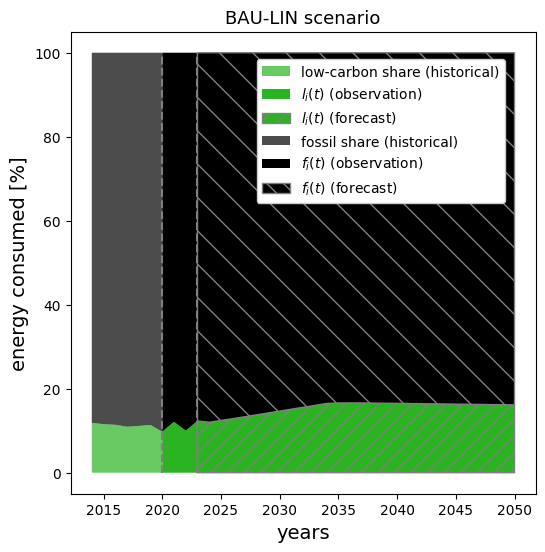

In [177]:
fig, ax = plt.subplots(figsize = (6,6))

years_hist = np.arange(2014,2021,1)
years_obs = np.arange(2020,2024,1)
years_pred = np.arange(2023,2051,1)

# fossil_vals = df_bau_LIN[df_bau_LIN["type"]=="fossil"]["energy_consumed"]#.values/10**9
lowcarbon_elec_vals_hist = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]>=2020) & (df_bau_LIN["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]>=2020) & (df_bau_LIN["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]>=2023)]["energy_consumed"]


ax.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = 0.7)
ax.fill_between(years_hist,lowcarbon_elec_vals_hist,100, facecolor="#000000", alpha = 0.7)

ax.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
ax.fill_between(years_obs,lowcarbon_elec_vals_obs,100, facecolor="#000000", alpha = 1)

ax.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = 1)
ax.fill_between(years_pred,lowcarbon_elec_vals_pred,100, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = 1)

ax.set_ylabel("energy consumed [%]", fontsize = axis_label_fontsize)
ax.set_xlabel("years", fontsize = axis_label_fontsize)
ax.set_title("BAU-LIN scenario", fontsize = title_fontsize)
ax.vlines(x = 2023, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)
ax.vlines(x = 2020, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)

# Custom Legend Creation
legend_elements = [
    # Low-carbon energy
    Patch(facecolor='#2ab421', edgecolor='none', alpha=0.7, label='low-carbon share (historical)'),
    Patch(facecolor='#2ab421', edgecolor='none', alpha=1, label='$l_i(t)$ (observation)'),
    Patch(facecolor='#2ab421', edgecolor='gray', hatch='//', label='$l_i(t)$ (forecast)'),
    
    # Fossil energy
    Patch(facecolor='#000000', edgecolor='none', alpha=0.7, label='fossil share (historical)'),
    Patch(facecolor='#000000', edgecolor='none', alpha=1, label='$f_i(t)$ (observation)'),
    Patch(facecolor='#000000', edgecolor='gray', hatch='\\\\', label='$f_i(t)$ (forecast)')
]

# Adding the custom legend to the plot
ax.legend(handles=legend_elements, framealpha = 1, loc = (0.4,0.63))



## business-as-usual (high ambition) scenario

In [178]:
df_bau_EXP = pd.read_csv("results/energy_consumption_firms_2020-2023.csv")
df_bau_EXP

i = 4
for year in range(2024,2051):
    hungary_lowcarbon_elec_share = df_forecast[df_forecast.year==year].lowcarbon_elec_share.values[0]
    df_bau_EXP["EXP_lowcarbon_elec_share_{}".format(year)] = (np.exp(df_bau_EXP["elec_rate"]*i)*df_bau_EXP["elec_rate_initial_value"])*hungary_lowcarbon_elec_share
    df_bau_EXP["EXP_lowcarbon_elec_share_{}".format(year)] = df_bau_EXP["EXP_lowcarbon_elec_share_{}".format(year)].clip(lower=0,upper = 1)
    i += 1

for year in range(2024,2051):
    df_bau_EXP["EXP_fossil_share_{}".format(year)] = 1 - df_bau_EXP["EXP_lowcarbon_elec_share_{}".format(year)]

for year in range(2024,2051):
    df_bau_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_bau_EXP["avg_total_consumption_KWH"]*df_bau_EXP["EXP_lowcarbon_elec_share_{}".format(year)]
    df_bau_EXP["EXP_lowcarbon_elec_consumption_rel_{}".format(year)] = df_bau_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_bau_EXP["avg_total_consumption_KWH"].sum()


for year in range(2024,2051):
    df_bau_EXP["EXP_fossil_consumption_KWH_{}".format(year)] = df_bau_EXP["avg_total_consumption_KWH"]*df_bau_EXP["EXP_fossil_share_{}".format(year)]
    df_bau_EXP["EXP_fossil_consumption_rel_{}".format(year)] = df_bau_EXP["EXP_fossil_consumption_KWH_{}".format(year)]/df_bau_EXP["avg_total_consumption_KWH"].sum()

df_bau_EXP = pd.DataFrame(df_bau_EXP.loc[:,"EXP_lowcarbon_elec_consumption_KWH_2024":].sum()).reset_index().rename(columns = {"index":"source_year",0:"energy_consumed"})
df_bau_EXP['type'] = df_bau_EXP['source_year'].apply(lambda x: x.split('_')[1])  # Extract the energy source
df_bau_EXP['year'] = df_bau_EXP['source_year'].apply(lambda x: x.split('_')[-1])  

# Convert the 'year' column to integer type
df_bau_EXP['year'] = df_bau_EXP['year'].astype(int)
df_bau_EXP = df_bau_EXP[df_bau_EXP["energy_consumed"]<=1]
df_bau_EXP = pd.concat([df_observed,df_bau_EXP], axis = 0)
df_bau_EXP = pd.concat([df_hist_final,df_bau_EXP], axis = 0)
df_bau_EXP["energy_consumed"] = df_bau_EXP["energy_consumed"]*100
df_bau_EXP



C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\352294739.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bau_EXP["EXP_lowcarbon_elec_consumption_rel_{}".format(year)] = df_bau_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_bau_EXP["avg_total_consumption_KWH"].sum()
C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\352294739.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bau_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_bau_EXP["avg_total_consumption_KWH"]*df_bau_EXP["EXP_low

,energy_consumed,type,year,source_year
0,11.869692,lowcarbon,2014,NaN
1,11.565927,lowcarbon,2015,NaN
2,11.410677,lowcarbon,2016,NaN
3,10.950057,lowcarbon,2017,NaN
4,11.150427,lowcarbon,2018,NaN
5,11.363530,lowcarbon,2019,NaN
0,88.130308,fossil,2014,NaN
1,88.434073,fossil,2015,NaN
2,88.589323,fossil,2016,NaN
3,89.049943,fossil,2017,NaN


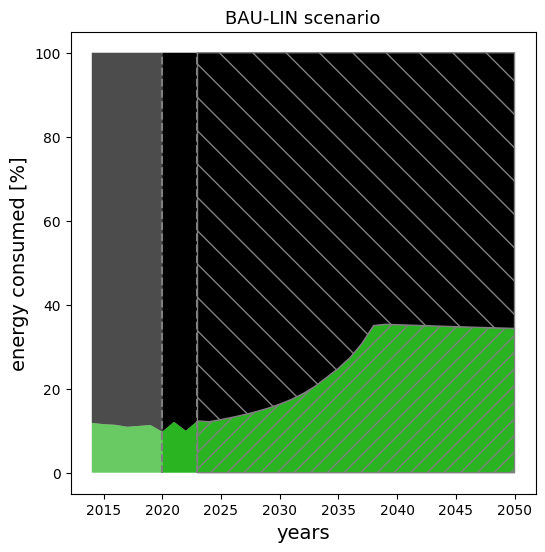

In [179]:
fig, ax = plt.subplots(figsize = (6,6))

years_hist = np.arange(2014,2021,1)
years_obs = np.arange(2020,2024,1)
years_pred = np.arange(2023,2051,1)

# fossil_vals = df_bau_LIN[df_bau_LIN["type"]=="fossil"]["energy_consumed"]#.values/10**9
lowcarbon_elec_vals_hist = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]>=2020) & (df_bau_EXP["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]>=2020) & (df_bau_EXP["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]>=2023)]["energy_consumed"]


ax.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = 0.7)
ax.fill_between(years_hist,lowcarbon_elec_vals_hist,100, facecolor="#000000", alpha = 0.7)

ax.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
ax.fill_between(years_obs,lowcarbon_elec_vals_obs,100, facecolor="#000000", alpha = 1)

ax.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = 1)
ax.fill_between(years_pred,lowcarbon_elec_vals_pred,100, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = 1)

ax.set_ylabel("energy consumed [%]", fontsize = axis_label_fontsize)
ax.set_xlabel("years", fontsize = axis_label_fontsize)
ax.set_title("BAU-LIN scenario", fontsize = title_fontsize)
ax.vlines(x = 2023, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)
ax.vlines(x = 2020, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)

# Custom Legend Creation
legend_elements = [
    # Low-carbon energy
    Patch(facecolor='#2ab421', edgecolor='none', alpha=0.7, label='low-carbon share (historical)'),
    Patch(facecolor='#2ab421', edgecolor='none', alpha=1, label='$l_i(t)$ (observation)'),
    Patch(facecolor='#2ab421', edgecolor='gray', hatch='//', label='$l_i(t)$ (forecast)'),
    
    # Fossil energy
    Patch(facecolor='#000000', edgecolor='none', alpha=0.7, label='fossil share (historical)'),
    Patch(facecolor='#000000', edgecolor='none', alpha=1, label='$f_i(t)$ (observation)'),
    Patch(facecolor='#000000', edgecolor='gray', hatch='\\\\', label='$f_i(t)$ (forecast)')
]

# Adding the custom legend to the plot
# ax.legend(handles=legend_elements, framealpha = 1, loc = (0.4,0.63))



## transition scenario

In [180]:
df_trans_LIN = df.copy(deep = True)
df_trans_LIN.iloc[:]

i = 4
for year in range(2024,2051):
    hungary_lowcarbon_elec_share = df_forecast[df_forecast.year==year].lowcarbon_elec_share.values[0]
    df_trans_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)] = (df_trans_LIN["trans_elec_trend"]*i + df_trans_LIN["trans_elec_intercept"])*hungary_lowcarbon_elec_share
    df_trans_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)] = df_trans_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)].clip(lower=0,upper = 1)
    i += 1

for year in range(2024,2051):
    df_trans_LIN["LINEAR_fossil_share_{}".format(year)] = 1 - df_trans_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)]

for year in range(2024,2051):
    df_trans_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_trans_LIN["avg_total_consumption_KWH"]*df_trans_LIN["LINEAR_lowcarbon_elec_share_{}".format(year)]
    df_trans_LIN["LINEAR_lowcarbon_elec_consumption_rel_{}".format(year)] = df_trans_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_trans_LIN["avg_total_consumption_KWH"].sum()


for year in range(2024,2051):
    df_trans_LIN["LINEAR_fossil_consumption_KWH_{}".format(year)] = df_trans_LIN["avg_total_consumption_KWH"]*df_trans_LIN["LINEAR_fossil_share_{}".format(year)]
    df_trans_LIN["LINEAR_fossil_consumption_rel_{}".format(year)] = df_trans_LIN["LINEAR_fossil_consumption_KWH_{}".format(year)]/df_trans_LIN["avg_total_consumption_KWH"].sum()

df_trans_LIN = pd.DataFrame(df_trans_LIN.loc[:,"LINEAR_lowcarbon_elec_consumption_KWH_2024":].sum()).reset_index().rename(columns = {"index":"source_year",0:"energy_consumed"})
# df_bau_LIN["year"] = df_bau_LIN["source_year"].apply(lambda x: int(x[-4:]))
df_trans_LIN['type'] = df_trans_LIN['source_year'].apply(lambda x: x.split('_')[1])  # Extract the energy source
df_trans_LIN['year'] = df_trans_LIN['source_year'].apply(lambda x: x.split('_')[-1])  

# Convert the 'year' column to integer type
df_trans_LIN['year'] = df_trans_LIN['year'].astype(int)
df_trans_LIN = df_trans_LIN[df_trans_LIN["energy_consumed"]<=1]
df_trans_LIN = pd.concat([df_observed,df_trans_LIN], axis = 0)
df_trans_LIN = pd.concat([df_hist_final,df_trans_LIN], axis = 0)
df_trans_LIN["energy_consumed"] = df_trans_LIN["energy_consumed"]*100
df_trans_LIN

C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\2326980716.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans_LIN["LINEAR_lowcarbon_elec_consumption_rel_{}".format(year)] = df_trans_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_trans_LIN["avg_total_consumption_KWH"].sum()
C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\2326980716.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans_LIN["LINEAR_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_trans_LIN["avg_total_consumption_KWH"

,energy_consumed,type,year,source_year
0,11.869692,lowcarbon,2014,NaN
1,11.565927,lowcarbon,2015,NaN
2,11.410677,lowcarbon,2016,NaN
3,10.950057,lowcarbon,2017,NaN
4,11.150427,lowcarbon,2018,NaN
5,11.363530,lowcarbon,2019,NaN
0,88.130308,fossil,2014,NaN
1,88.434073,fossil,2015,NaN
2,88.589323,fossil,2016,NaN
3,89.049943,fossil,2017,NaN


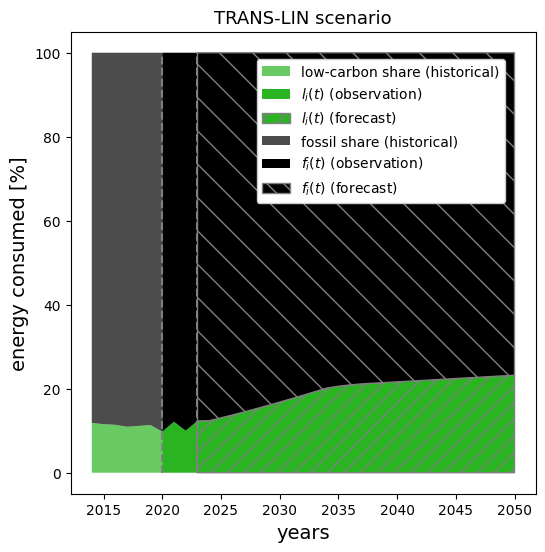

In [181]:
fig, ax = plt.subplots(figsize = (6,6))

years_hist = np.arange(2014,2021,1)
years_obs = np.arange(2020,2024,1)
years_pred = np.arange(2023,2051,1)

# fossil_vals = df_bau_LIN[df_bau_LIN["type"]=="fossil"]["energy_consumed"]#.values/10**9
lowcarbon_elec_vals_hist = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]>=2020) & (df_trans_LIN["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]>=2020) & (df_trans_LIN["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]>=2023)]["energy_consumed"]


ax.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = 0.7)
ax.fill_between(years_hist,lowcarbon_elec_vals_hist,100, facecolor="#000000", alpha = 0.7)

ax.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
ax.fill_between(years_obs,lowcarbon_elec_vals_obs,100, facecolor="#000000", alpha = 1)

ax.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = 1)
ax.fill_between(years_pred,lowcarbon_elec_vals_pred,100, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = 1)

ax.set_ylabel("energy consumed [%]", fontsize = axis_label_fontsize)
ax.set_xlabel("years", fontsize = axis_label_fontsize)
ax.set_title("TRANS-LIN scenario", fontsize = title_fontsize)
ax.vlines(x = 2023, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)
ax.vlines(x = 2020, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)

# Custom Legend Creation
legend_elements = [
    # Low-carbon energy
    Patch(facecolor='#2ab421', edgecolor='none', alpha=0.7, label='low-carbon share (historical)'),
    Patch(facecolor='#2ab421', edgecolor='none', alpha=1, label='$l_i(t)$ (observation)'),
    Patch(facecolor='#2ab421', edgecolor='gray', hatch='//', label='$l_i(t)$ (forecast)'),
    
    # Fossil energy
    Patch(facecolor='#000000', edgecolor='none', alpha=0.7, label='fossil share (historical)'),
    Patch(facecolor='#000000', edgecolor='none', alpha=1, label='$f_i(t)$ (observation)'),
    Patch(facecolor='#000000', edgecolor='gray', hatch='\\\\', label='$f_i(t)$ (forecast)')
]

# Adding the custom legend to the plot
ax.legend(handles=legend_elements, framealpha = 1, loc = (0.4,0.63))



## best-case transition scenario

In [182]:
df_trans_EXP = df.copy(deep = True)
df_trans_EXP

i = 4
for year in range(2024,2051):
    hungary_lowcarbon_elec_share = df_forecast[df_forecast.year==year].lowcarbon_elec_share.values[0]
    df_trans_EXP["EXP_lowcarbon_elec_share_{}".format(year)] = (np.exp(df_trans_EXP["trans_elec_rate"]*i)*df_trans_EXP["trans_elec_initial_value"])*hungary_lowcarbon_elec_share
    df_trans_EXP["EXP_lowcarbon_elec_share_{}".format(year)] = df_trans_EXP["EXP_lowcarbon_elec_share_{}".format(year)].clip(lower=0,upper = 1)
    i += 1

for year in range(2024,2051):
    df_trans_EXP["EXP_fossil_share_{}".format(year)] = 1 - df_trans_EXP["EXP_lowcarbon_elec_share_{}".format(year)]

for year in range(2024,2051):
    df_trans_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_trans_EXP["avg_total_consumption_KWH"]*df_trans_EXP["EXP_lowcarbon_elec_share_{}".format(year)]
    df_trans_EXP["EXP_lowcarbon_elec_consumption_rel_{}".format(year)] = df_trans_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_trans_EXP["avg_total_consumption_KWH"].sum()


for year in range(2024,2051):
    df_trans_EXP["EXP_fossil_consumption_KWH_{}".format(year)] = df_trans_EXP["avg_total_consumption_KWH"]*df_trans_EXP["EXP_fossil_share_{}".format(year)]
    df_trans_EXP["EXP_fossil_consumption_rel_{}".format(year)] = df_trans_EXP["EXP_fossil_consumption_KWH_{}".format(year)]/df_trans_EXP["avg_total_consumption_KWH"].sum()


df_trans_EXP = pd.DataFrame(df_trans_EXP.loc[:,"EXP_lowcarbon_elec_consumption_KWH_2024":].sum()).reset_index().rename(columns = {"index":"source_year",0:"energy_consumed"})
# df_bau_LIN["year"] = df_bau_LIN["source_year"].apply(lambda x: int(x[-4:]))
df_trans_EXP['type'] = df_trans_EXP['source_year'].apply(lambda x: x.split('_')[1])  # Extract the energy source
df_trans_EXP['year'] = df_trans_EXP['source_year'].apply(lambda x: x.split('_')[-1])  

# Convert the 'year' column to integer type
df_trans_EXP['year'] = df_trans_EXP['year'].astype(int)
df_trans_EXP = df_trans_EXP[df_trans_EXP["energy_consumed"]<=1]
df_trans_EXP = pd.concat([df_observed,df_trans_EXP], axis = 0)
df_trans_EXP = pd.concat([df_hist_final,df_trans_EXP], axis = 0)
df_trans_EXP["energy_consumed"] = df_trans_EXP["energy_consumed"]*100

C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\1810656364.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans_EXP["EXP_lowcarbon_elec_consumption_rel_{}".format(year)] = df_trans_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)]/df_trans_EXP["avg_total_consumption_KWH"].sum()
C:\Users\Johannes\AppData\Local\Temp\ipykernel_6932\1810656364.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans_EXP["EXP_lowcarbon_elec_consumption_KWH_{}".format(year)] = df_trans_EXP["avg_total_consumption_KWH"]*df_tran

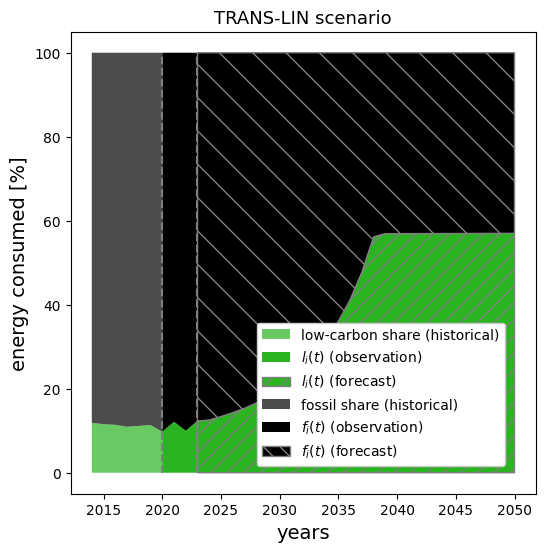

In [183]:
fig, ax = plt.subplots(figsize = (6,6))

years_hist = np.arange(2014,2021,1)
years_obs = np.arange(2020,2024,1)
years_pred = np.arange(2023,2051,1)

# fossil_vals = df_bau_LIN[df_bau_LIN["type"]=="fossil"]["energy_consumed"]#.values/10**9
lowcarbon_elec_vals_hist = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]>=2020) & (df_trans_EXP["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]>=2020) & (df_trans_EXP["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]>=2023)]["energy_consumed"]


ax.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = 0.7)
ax.fill_between(years_hist,lowcarbon_elec_vals_hist,100, facecolor="#000000", alpha = 0.7)

ax.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
ax.fill_between(years_obs,lowcarbon_elec_vals_obs,100, facecolor="#000000", alpha = 1)

ax.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = 1)
ax.fill_between(years_pred,lowcarbon_elec_vals_pred,100, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = 1)

ax.set_ylabel("energy consumed [%]", fontsize = axis_label_fontsize)
ax.set_xlabel("years", fontsize = axis_label_fontsize)
ax.set_title("TRANS-LIN scenario", fontsize = title_fontsize)
ax.vlines(x = 2023, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)
ax.vlines(x = 2020, ymin = 0, ymax = 100, linestyle = "--", color = "gray",)

# Custom Legend Creation
legend_elements = [
    # Low-carbon energy
    Patch(facecolor='#2ab421', edgecolor='none', alpha=0.7, label='low-carbon share (historical)'),
    Patch(facecolor='#2ab421', edgecolor='none', alpha=1, label='$l_i(t)$ (observation)'),
    Patch(facecolor='#2ab421', edgecolor='gray', hatch='//', label='$l_i(t)$ (forecast)'),
    
    # Fossil energy
    Patch(facecolor='#000000', edgecolor='none', alpha=0.7, label='fossil share (historical)'),
    Patch(facecolor='#000000', edgecolor='none', alpha=1, label='$f_i(t)$ (observation)'),
    Patch(facecolor='#000000', edgecolor='gray', hatch='\\\\', label='$f_i(t)$ (forecast)')
]

# Adding the custom legend to the plot
ax.legend(handles=legend_elements, framealpha = 1, loc = (0.4,0.06))



## Combined Figure

In [184]:
df_bau_LIN["energy_consumed"] = np.round(df_bau_LIN["energy_consumed"] / 100, 3)

df_bau_EXP["energy_consumed"] = np.round(df_bau_EXP["energy_consumed"] / 100, 3)

df_trans_LIN["energy_consumed"] = np.round(df_trans_LIN["energy_consumed"] / 100, 3)

df_trans_EXP["energy_consumed"] = np.round(df_trans_EXP["energy_consumed"] / 100, 3)


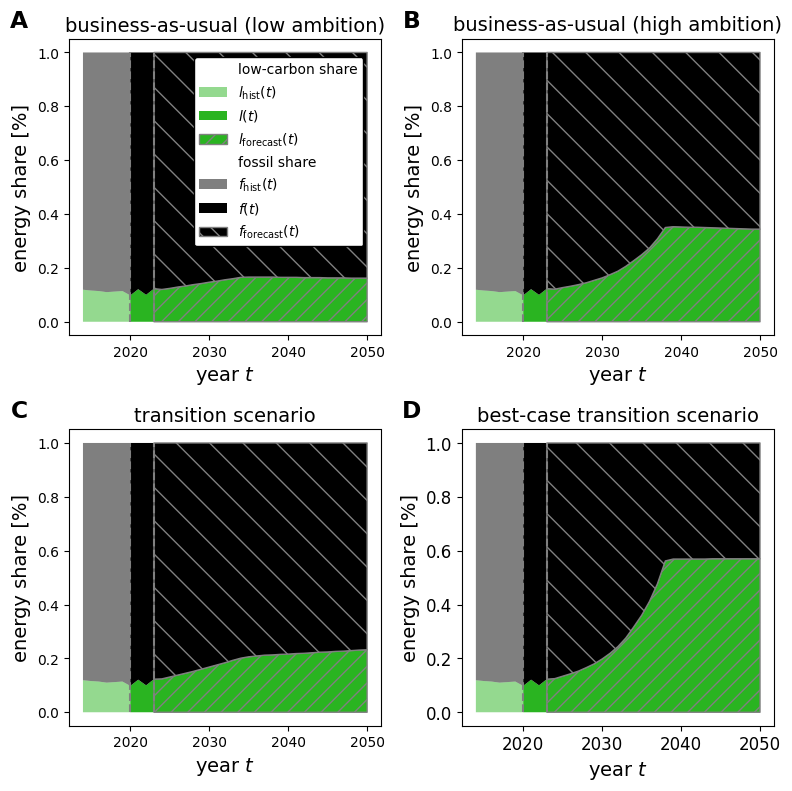

In [185]:
axis_label_fontsize = 14
legend_fontsize = 8
ticks_fontsize = 11
title_fontsize = 15

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

years_hist = np.arange(2014,2021,1)
years_obs = np.arange(2020,2024,1)
years_pred = np.arange(2023,2051,1)

alpha_hist = 0.5
alpha_pred = 1


# Custom Legend Creation
legend_elements = [
    # Low-carbon share header
    Line2D([0], [0], color='white', label='low-carbon share'),
    
    # Low-carbon energy shares
    Patch(facecolor='#2ab421', edgecolor='none', alpha=alpha_hist, label=r'$l_{\text{hist}}(t)$'),
    Patch(facecolor='#2ab421', edgecolor='none', alpha=1, label=r'$l(t)$'),
    Patch(facecolor='#2ab421', edgecolor='gray', alpha=alpha_pred, hatch='//', label=r'$l_{\text{forecast}}(t)$'),
    
    # Fossil share header
    Line2D([0], [0], color='white', label='fossil share'),
    
    # Fossil energy shares
    Patch(facecolor='#000000', edgecolor='none', alpha=alpha_hist, label=r'$f_{\text{hist}}(t)$'),
    Patch(facecolor='#000000', edgecolor='none', alpha=1, label=r'$f(t)$'),
    Patch(facecolor='#000000', edgecolor='gray', alpha=alpha_pred, hatch='\\\\', label=r'$f_{\text{forecast}}(t)$')
]

# Rename the axes
axa = axs[0, 0]
axb = axs[0, 1]
axc = axs[1, 0]
axd = axs[1, 1]

# Subplot 1
lowcarbon_elec_vals_hist = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]>=2020) & (df_bau_LIN["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_bau_LIN[(df_bau_LIN["type"]=="lowcarbon") & (df_bau_LIN["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]>=2020) & (df_bau_LIN["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_bau_LIN[(df_bau_LIN["type"]=="fossil") & (df_bau_LIN["year"]>=2023)]["energy_consumed"]

axa.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = alpha_hist)
axa.fill_between(years_hist,lowcarbon_elec_vals_hist,1, facecolor="#000000", alpha = alpha_hist)

axa.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
axa.fill_between(years_obs,lowcarbon_elec_vals_obs,1, facecolor="#000000", alpha = 1)

axa.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = alpha_pred)
axa.fill_between(years_pred,lowcarbon_elec_vals_pred,1, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = alpha_pred)

axa.set_ylabel("energy share [%]", fontsize = axis_label_fontsize)
axa.set_xlabel("year $t$", fontsize = axis_label_fontsize)
axa.set_title("business-as-usual (low ambition)", fontsize = axis_label_fontsize)
axa.vlines(x = 2023, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
axa.vlines(x = 2020, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
# axa.legend(handles=legend_elements, fontsize = 8, framealpha = 1, loc = (0.3,0.56))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Subplot 2
lowcarbon_elec_vals_hist = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]>=2020) & (df_bau_EXP["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_bau_EXP[(df_bau_EXP["type"]=="lowcarbon") & (df_bau_EXP["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]>=2020) & (df_bau_EXP["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_bau_EXP[(df_bau_EXP["type"]=="fossil") & (df_bau_EXP["year"]>=2023)]["energy_consumed"]

axb.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = alpha_hist)
axb.fill_between(years_hist,lowcarbon_elec_vals_hist,1, facecolor="#000000", alpha = alpha_hist)

axb.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
axb.fill_between(years_obs,lowcarbon_elec_vals_obs,1, facecolor="#000000", alpha = 1)

axb.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = alpha_pred)
axb.fill_between(years_pred,lowcarbon_elec_vals_pred,1, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = alpha_pred)

axb.set_ylabel("energy share [%]", fontsize = axis_label_fontsize)
axb.set_xlabel("year $t$", fontsize = axis_label_fontsize)
axb.set_title("business-as-usual (high ambition)", fontsize = axis_label_fontsize)
axb.vlines(x = 2023, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
axb.vlines(x = 2020, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
axa.legend(handles=legend_elements, fontsize = legend_fontsize + 2, framealpha = 1, 
           loc = (0.4,0.3), 
           frameon=True, edgecolor="black", facecolor="white")
# axb.legend(
#     handles=legend_elements,
#     labels=['Low-carbon share', '$l_{\text{hist}}(t)$', '$l_i(t)$', '$l_{\text{forecast}}(t)$',
#             'Fossil share', '$f_{\text{hist}}(t)$', '$f_i(t)$', '$f_{\text{forecast}}(t)$'],
#     title='Energy Shares',
#     loc='upper left',  # Place the legend box in the upper left of the figure
#     fontsize=12,
#     title_fontsize=14,
#     bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
#     borderpad=1,
#     handleheight=2.5  # Adjust handle height for clarity
# )

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Subplot 3
lowcarbon_elec_vals_hist = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]>=2020) & (df_trans_LIN["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_trans_LIN[(df_trans_LIN["type"]=="lowcarbon") & (df_trans_LIN["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]>=2020) & (df_trans_LIN["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_trans_LIN[(df_trans_LIN["type"]=="fossil") & (df_trans_LIN["year"]>=2023)]["energy_consumed"]

axc.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = alpha_hist)
axc.fill_between(years_hist,lowcarbon_elec_vals_hist,1, facecolor="#000000", alpha = alpha_hist)

axc.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
axc.fill_between(years_obs,lowcarbon_elec_vals_obs,1, facecolor="#000000", alpha = 1)

axc.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = alpha_pred)
axc.fill_between(years_pred,lowcarbon_elec_vals_pred,1, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = alpha_pred)

axc.set_ylabel("energy share [%]", fontsize = axis_label_fontsize)
axc.set_xlabel("year $t$", fontsize = axis_label_fontsize)
axc.set_title("transition scenario", fontsize = axis_label_fontsize)
axc.vlines(x = 2023, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
axc.vlines(x = 2020, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
# axc.legend(handles=legend_elements, fontsize = 7, framealpha = 1, loc = (0.38,0.06))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Subplot 4
lowcarbon_elec_vals_hist = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]<=2020)]["energy_consumed"]
lowcarbon_elec_vals_obs = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]>=2020) & (df_trans_EXP["year"]<=2023)]["energy_consumed"]
lowcarbon_elec_vals_pred = df_trans_EXP[(df_trans_EXP["type"]=="lowcarbon") & (df_trans_EXP["year"]>=2023)]["energy_consumed"]

fossil_elec_vals_hist = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]<=2020)]["energy_consumed"]
fossil_elec_vals_obs = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]>=2020) & (df_trans_EXP["year"]<=2023)]["energy_consumed"]
fossil_elec_vals_pred = df_trans_EXP[(df_trans_EXP["type"]=="fossil") & (df_trans_EXP["year"]>=2023)]["energy_consumed"]

axd.fill_between(years_hist,0,lowcarbon_elec_vals_hist, facecolor="#2ab421", alpha = alpha_hist)
axd.fill_between(years_hist,lowcarbon_elec_vals_hist,1, facecolor="#000000", alpha = alpha_hist)

axd.fill_between(years_obs,0,lowcarbon_elec_vals_obs, facecolor="#2ab421", alpha = 1)
axd.fill_between(years_obs,lowcarbon_elec_vals_obs,1, facecolor="#000000", alpha = 1)

axd.fill_between(years_pred,0,lowcarbon_elec_vals_pred, facecolor="#2ab421", hatch = "//", edgecolor = "gray", alpha = alpha_pred)
axd.fill_between(years_pred,lowcarbon_elec_vals_pred,1, facecolor="#000000", hatch = "\\", edgecolor = "gray", alpha = alpha_pred)

axd.set_ylabel("energy share [%]", fontsize = axis_label_fontsize)
axd.set_xlabel("year $t$", fontsize = axis_label_fontsize)
axd.set_title("best-case transition scenario", fontsize = axis_label_fontsize)
axd.vlines(x = 2023, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
axd.vlines(x = 2020, ymin = 0, ymax = 1, linestyle = "--", color = "gray",)
# axd.legend(handles=legend_elements, fontsize = legend_fontsize, framealpha = 1, loc = (0.38,0.06))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# axd.legend(handles=legend_elements, fontsize = 7, framealpha = 1, loc = (0.38,0.06))

# add letters
xpos, ypos = -0.13, 1.1

def insert_letter(a, lett):
    a.text(xpos, ypos,lett,
           fontdict={ 'size':str(axis_label_fontsize*1.2)}, transform=a.transAxes,
          zorder=100000, va='top', ha='right', weight='bold')
    
for a,l in zip([axa,axb,axc,axd],['A','B','C','D']):
    insert_letter(a,l)


# Adjust layout
plt.tight_layout()

plt.savefig("plots/FIG4_scenarios.pdf", bbox_inches = "tight",dpi = 300)